# Microcanonical and finite-temperature ab initio molecular dynamics simulations on quantum computers

## 项目介绍

This paper mainly used different types of VQE to simulate hydrogen and trihydrogen ion, which are respectively through the method of tapering off number of qubits the from parity form of Hamiltonian of hydrogen and seniority-zero Hamiltonian of trihydrogen ion in the first part. In another part of this paper, they experimented with algorithms on real a quantum computer and provide solutions for the alleviation of the statistical noise associated with the measurements of the expectation values of energies and forces, as well as schemes for the mitigation of the hardware noise sources.

This recurrence mainly reproduced FIG.3. in this paper,i.e. the simulation of hydrogen.

100%|██████████| 350/350 [00:43<00:00,  7.97it/s]


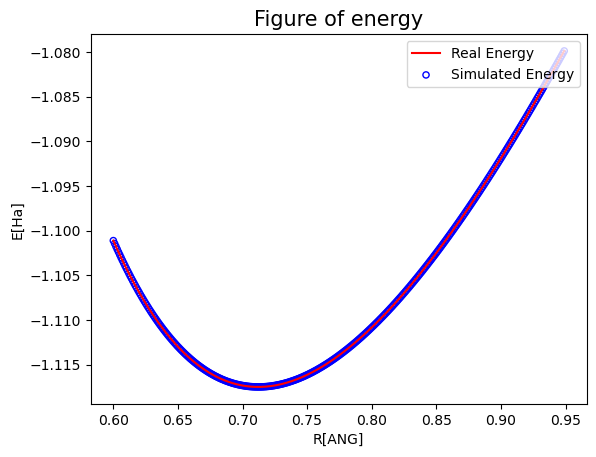

<Figure size 640x480 with 0 Axes>

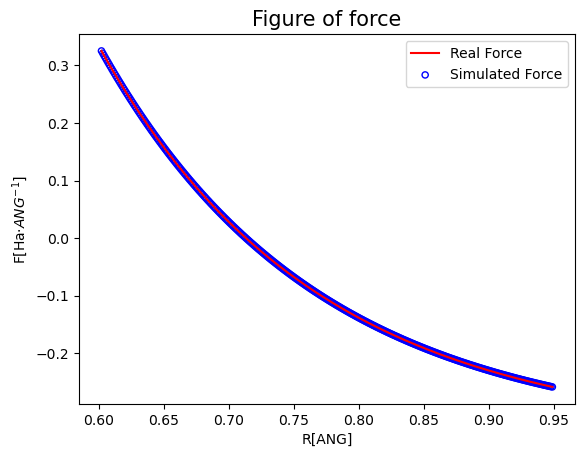

<Figure size 640x480 with 0 Axes>

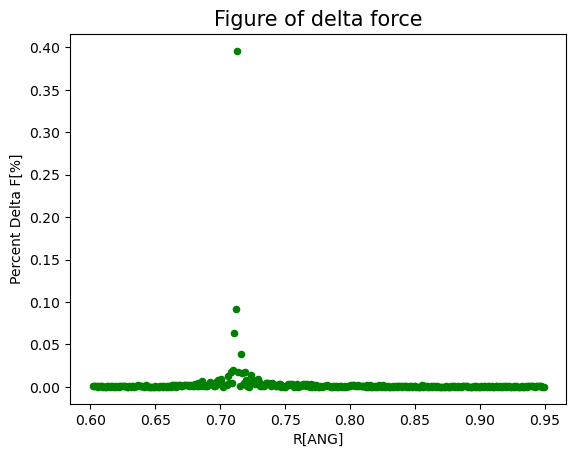

<Figure size 640x480 with 0 Axes>

In [10]:
## 复现过程
import numpy as np
from mindquantum.core.gates import X, RX, RY, RZ
from mindquantum import InteractionOperator, QubitOperator, Transform ,Simulator, Circuit, Hamiltonian, get_fermion_operator
from mindquantum.core.parameterresolver import ParameterResolver
import math
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
import matplotlib.pylab as plt

## 制造U3量子门
def U3(ansatz, No, index_theta):
    ansatz += RY(f'theta{index_theta}').on(No)

## 制造U2量子门
def U2(ansatz, No):
    pi=math.pi
    alpha0, alpha1 = ParameterResolver('alpha0'), ParameterResolver('alpha1')
    alpha0.as_encoder()
    alpha1.as_encoder()

    ansatz += RZ(alpha0).on(No)
    ansatz += RZ(pi/2).on(No)
    ansatz += RX(pi/2).on(No)
    ansatz += RZ(alpha1).on(No)
    ansatz += RZ(-pi/2).on(No)

## 构建ansatz ##
def Iniansatz():
    ansatz = Circuit()
    ansatz += X.on(0)
    U3(ansatz,0,0)
    U3(ansatz,1,1)
    U2(ansatz,1)
    ansatz += X.on(1,0)
    U3(ansatz,0,2)
    U2(ansatz,1)
    U3(ansatz,1,3)
    return ansatz

## 产生氢分子模型 ##
def product_hydrogen(L):
    dist = L
    geometry = [
        ["H", [0.0, 0.0, 0.0 * dist]],
        ["H", [0.0, 0.0, 1.0 * dist]],
    ]
    basis = "sto3g"
    spin = 0
    molecule_of = MolecularData(
        geometry,
        basis,
        multiplicity=2 * spin + 1
    )
    molecule_of = run_pyscf(
        molecule_of,
        run_scf=1,
    )
    return molecule_of

## tapering off 减少量子比特数 ##
def reduced_hq(hamiltonian_QubitOp,nqubits):
    Terms = list(hamiltonian_QubitOp.terms.keys())
    coeff = list(hamiltonian_QubitOp.terms.values())
    pauli_gates = ('X','Y','Z')
    indexes_q = range(nqubits)
    recorder_qg = np.zeros(shape=(3*nqubits),dtype=np.int8)
    recorder_q = np.zeros(shape=(nqubits),dtype=np.int8)
    positions_zero = []
    ## 记录各个比特经历的各个泡利门个数到recorder_qg ##
    for terms in Terms:
        for term in terms:
            for index in indexes_q:
                for p in range(3):
                    pauli_gate = pauli_gates[p]
                    if term[0] == index and term[1] == pauli_gate:
                        recorder_qg[3*index + p] += 1
    ## 标记将会被tapering off的比特到reocorder_q ##
    start_con = 0
    while (start_con < len(recorder_qg)):
        temp_group = recorder_qg[start_con:start_con+3]
        if np.sum(np.where(temp_group,0,1))==2:
            positions_zero.append(start_con+int(np.where(temp_group!=0)[0]))
            temp_index = math.floor(start_con/3)
            recorder_q[temp_index] = 1
        start_con += 3
    ## tapering off ##
    for position_zero in positions_zero:
        index_gate = position_zero%3
        index_q = math.floor(position_zero/3)
        for i in range(len(Terms)):
            for j in range(len(Terms[i])):
                term = Terms[i][j]
                if term[0] == index_q and term[1] == pauli_gates[index_gate]:
                    terms = list(Terms[i])
                    del terms[j]
                    Terms[i] = tuple(terms)
                    break
    ## 将剩余比特编号根据reorder_q中的记录往前推 ##
    for i in range(len(Terms)):
        for j in range(len(Terms[i])):
            index_q = Terms[i][j][0]
            index_err = recorder_q[:index_q].sum()
            index_q -= index_err
            terms = list(Terms[i])
            temp = (index_q,terms[j][1])
            terms[j] = temp
            Terms[i] = tuple(terms)
    ## 创建新的QubitOperator ##
    newops = QubitOperator()
    for i in range(len(coeff)):
        terms = Terms[i]
        temp = ''
        for j in range(len(terms)):
            temp += terms[j][1] + str(terms[j][0]) + ' '
        newops += QubitOperator(temp,coeff[i])
    return newops

## 构建优化函数 ##
def measure_result(total_params):
    theta0, theta1, theta2, theta3 = total_params[2:]
    alpha0, alpha1 = total_params[0:2]
    encoder_data = np.array([[alpha0, alpha1]]).astype(np.float32)
    ansatz_data = np.array([theta0, theta1, theta2, theta3]).astype(np.float32)
    measure_result, _, _ = grad_ops(encoder_data, ansatz_data)
    return np.real(measure_result)

import tqdm
## 主函数 ##
if __name__ == '__main__':
    start = 600 #设定循环起点
    end = 950  #设定循环终点
    t = 1000 #设定比例系数
    delta_r = 1/t #设定间距步长
    real_energy = [] #初始化能量真值记录列表
    measured_energy = [] #初始化能量测量值记录列表
    real_force = [] #初始化力真值记录列表
    measured_force = [] #初始化力测量值记录列表
    delta_force = [] #初始化力差值记录列表
    X_L_E = [] #初始化分子间距记录列表（能量）
    X_L_F = [] #初始化分子间距纪录列表（力）
    for i in tqdm.tqdm(range(start,end)):
        L = i/t #导出分子间距
        X_L_E.append(L) #记录分子间距
        molecule_of = product_hydrogen(L) #制造氢分子模型
        real_energy.append(molecule_of.hf_energy.real) #记录能量真值
        m_ham = molecule_of.get_molecular_hamiltonian() #获取哈密顿量
        ini_ham = InteractionOperator(*(m_ham.n_body_tensors.values())) #初始化哈密顿量operator
        hamiltonian_QubitOp = Transform(get_fermion_operator(ini_ham)).parity() #用parity的方式转化为QubitOperator
        newops = reduced_hq(hamiltonian_QubitOp, 4) #减少比特数

        total_params = [0, np.pi, 0, 0, 0, 0] #参数初始化
        ansatz = Iniansatz() #初始化量子线路

        nqubits = 2 #设置量子线路量子比特数
        sim = Simulator('mqvector', nqubits) #初始化模拟器
        grad_ops = sim.get_expectation_with_grad(Hamiltonian(newops), ansatz) #获得测量值和参数梯度

        mymin = minimize(measure_result,total_params,method='COBYLA') #用COBYLA进行优化
        measured_energy.append(mymin['fun']) #记录测量值
        if i > start+1 :
            j = i - start
            temp_real = -(real_energy[j] - real_energy[j-2])/(2*delta_r) #计算真值力
            temp_measured = -(measured_energy[j] - measured_energy[j-2])/(2*delta_r) #计算测量力
            temp_delta = (temp_measured - temp_real) / temp_real #计算力差值比率
            real_force.append(temp_real) #记录真值力
            measured_force.append(temp_measured) #记录测量力
            delta_force.append(np.abs(temp_delta)*100) #记录力差值比率
            X_L_F.append(L) #记录分子间距

    ## 绘图 ##
    plt.figure(1)
    plt.plot(X_L_E,real_energy,color='red')
    plt.scatter(X_L_E,measured_energy,marker='o',s = 20,facecolor = 'none',edgecolors='blue')
    plt.xlabel("R[ANG]")
    plt.ylabel("E[Ha]")
    plt.legend(['Real Energy','Simulated Energy'],loc='upper right')
    plt.title('Figure of energy',fontsize=15)
    plt.show()
    plt.savefig("result1.png")
    plt.figure(2)
    plt.plot(X_L_F,real_force,color='red')
    plt.scatter(X_L_F,measured_force,marker='o',s = 20,facecolor = 'none',edgecolors='blue')
    plt.xlabel("R[ANG]")
    plt.ylabel("F[Ha·$ANG^{-1}$]")
    plt.legend(['Real Force','Simulated Force'],loc='upper right')
    plt.title('Figure of force',fontsize=15)
    plt.show()
    plt.savefig("result2.png")
    plt.figure(3)
    plt.scatter(X_L_F,delta_force,s=20,color='green')
    plt.xlabel("R[ANG]")
    plt.ylabel("Percent Delta F[%]")
    plt.title('Figure of delta force',fontsize=15)
    plt.show()
    plt.savefig("result3.png")


## 项目总结

### 主要结果

After the work was done, I found:

1. VQE is a good method to simulate molecule, which produces a high accuracy.
2. Transform Hamiltonian to QubitOperator with the method of parity is good for the further taperting off to reduce qubits that are needed to simulate  hydrogen or maybe other symmetrical molecules.
3. Mindquantum is very convenient for VQE. Maybe it is better to add the function of tapering off.


### 创新点

A simple function for tapering off.